<a href="https://colab.research.google.com/github/summerolmstead/Sales-Prediction/blob/main/Pizza_Sales_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Project | Pizza Prediction Sales Forecasting

Summer, Jason, Victoria, Regan - Utilized Claude AI to help us build model

#Importing Data in

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhonarosecortez/pizza-sales-dataset") #importing from kaggle

print("Path to dataset files:", path) # path to the file

Path to dataset files: /root/.cache/kagglehub/datasets/rhonarosecortez/pizza-sales-dataset/versions/2


In [10]:
import os
dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

Dataset files: ['Pizza Sales Dataset.csv']


In [11]:
import pandas as pd
csv_file_path = os.path.join(path, 'Pizza Sales Dataset.csv')
df = pd.read_csv(csv_file_path)

print(df.head()) # seeing structure of data

   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella Cheese   
1  Pepperoni, Mushrooms, Red Onions, Red Peppers,...   
2 

In [12]:
# Print all unique values in the 'order_day' column
print(df['order_day'].unique())

# Print the first few rows of the dataframe to inspect
print(df.head())

['Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzar

# Basic Check of the Data

In [13]:
df.describe() # seeing summary statistics

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821474
std,14035.529381,6180.119770,0.143077,3.621789,4.437398
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


# Model

Training data: (286, 13)
Testing data: (72, 13)
MAE: 58.42
RMSE: 74.43
R²: 0.9797
MAPE: 2.61%


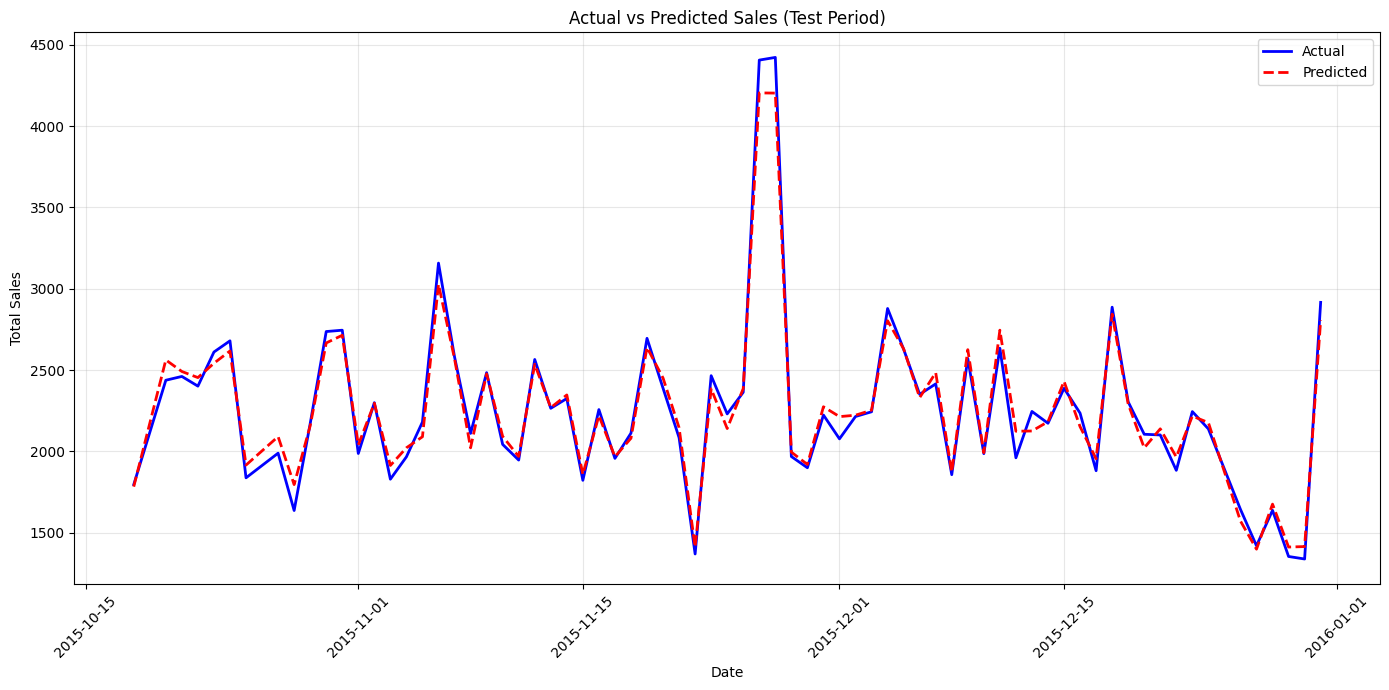

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

# Assuming df is your dataframe with order_date and sales data
# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Aggregate daily total sales
daily_sales = df.groupby('order_date').agg(
    total_sales=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    order_count=('order_id', 'nunique')
).reset_index()

# Sort by date
daily_sales = daily_sales.sort_values('order_date')

# Basic feature engineering
daily_sales['day'] = daily_sales['order_date'].dt.day
daily_sales['month'] = daily_sales['order_date'].dt.month
daily_sales['year'] = daily_sales['order_date'].dt.year
daily_sales['weekday'] = daily_sales['order_date'].dt.weekday
daily_sales['is_weekend'] = daily_sales['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features
for lag in [1, 7, 14]:
    daily_sales[f'lag_{lag}'] = daily_sales['total_sales'].shift(lag)

# Rolling statistics features
for window in [7, 14]:
    daily_sales[f'rolling_mean_{window}'] = daily_sales['total_sales'].rolling(window=window).mean()

# Simple cyclical encoding
daily_sales['month_sin'] = np.sin(2 * np.pi * daily_sales['month'] / 12)
daily_sales['month_cos'] = np.cos(2 * np.pi * daily_sales['month'] / 12)
daily_sales['weekday_sin'] = np.sin(2 * np.pi * daily_sales['weekday'] / 7)
daily_sales['weekday_cos'] = np.cos(2 * np.pi * daily_sales['weekday'] / 7)

# Average sales by weekday
weekday_avg = daily_sales.groupby('weekday')['total_sales'].transform('mean')
daily_sales['weekday_avg_sales'] = weekday_avg

# Fill NaNs or missing values
daily_sales = daily_sales.fillna(0)

# Select features
selected_features = [
    'total_quantity', 'order_count', 'is_weekend', 'weekday',
    'month', 'lag_1', 'lag_7', 'rolling_mean_7',
    'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
    'weekday_avg_sales'
]

X = daily_sales[selected_features]
y = daily_sales['total_sales']

# Time series split - last 20% for testing
split_idx = int(len(daily_sales) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost model with manually specified parameters
# These are reasonable default values that work well for many forecasting problems
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8
)

# Train model
model.fit(
    X_train_scaled,
    y_train
)

# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE: {mape:.2f}%')

# Plot actual vs. predicted for test data
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['order_date'].iloc[split_idx:].values, y_test.values,
         label='Actual', color='blue', linewidth=2)
plt.plot(daily_sales['order_date'].iloc[split_idx:].values, y_pred,
         label='Predicted', color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Actual vs Predicted Sales (Test Period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predicting Future 30 days

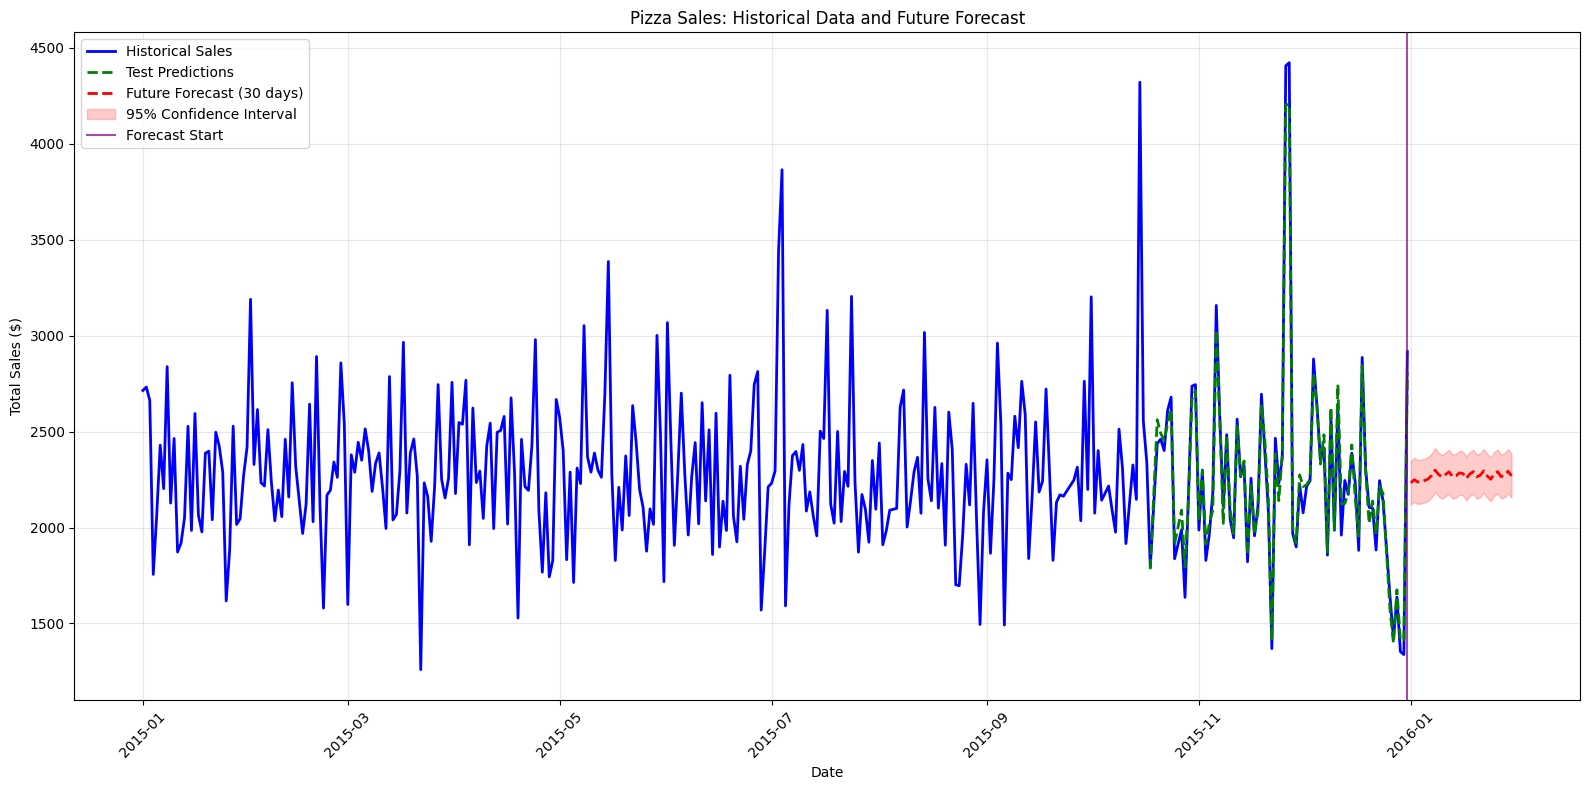


Forecast for Next 30 Days:
      Date   Weekday  Forecasted_Sales  Lower_Bound  Upper_Bound
2016-01-01    Friday       2232.863770  2118.358305  2347.369234
2016-01-02  Saturday       2248.883545  2134.378081  2363.389009
2016-01-03    Sunday       2236.893311  2122.387847  2351.398775
2016-01-04    Monday       2239.769287  2125.263823  2354.274751
2016-01-05   Tuesday       2244.966309  2130.460845  2359.471773
2016-01-06 Wednesday       2253.108643  2138.603179  2367.614107
2016-01-07  Thursday       2271.505859  2157.000395  2386.011323
2016-01-08    Friday       2299.052490  2184.547026  2413.557954
2016-01-09  Saturday       2276.136719  2161.631255  2390.642183
2016-01-10    Sunday       2263.796387  2149.290923  2378.301851
2016-01-11    Monday       2276.287109  2161.781645  2390.792573
2016-01-12   Tuesday       2290.297363  2175.791899  2404.802827
2016-01-13 Wednesday       2265.343750  2150.838286  2379.849214
2016-01-14  Thursday       2269.227783  2154.722319  2383.7332

In [18]:
# Predict future 30 days
last_date = daily_sales['order_date'].max()
future_dates = pd.date_range(last_date + timedelta(days=1), periods=30, freq='D')

# Create future features dataframe
future_df = pd.DataFrame({'order_date': future_dates})
future_df['day'] = future_df['order_date'].dt.day
future_df['month'] = future_df['order_date'].dt.month
future_df['year'] = future_df['order_date'].dt.year
future_df['weekday'] = future_df['order_date'].dt.weekday
future_df['is_weekend'] = future_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclical encoding
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
future_df['weekday_sin'] = np.sin(2 * np.pi * future_df['weekday'] / 7)
future_df['weekday_cos'] = np.cos(2 * np.pi * future_df['weekday'] / 7)

# Get weekday average sales from training data
weekday_avg_dict = daily_sales.groupby('weekday')['total_sales'].mean().to_dict()
future_df['weekday_avg_sales'] = future_df['weekday'].map(weekday_avg_dict)

# Initialize with average values
future_df['total_quantity'] = daily_sales['total_quantity'].mean()
future_df['order_count'] = daily_sales['order_count'].mean()

# Iterative forecasting - populate lag features one day at a time
combined_df = pd.concat([daily_sales[['order_date', 'total_sales']],
                       pd.DataFrame({'order_date': future_dates, 'total_sales': 0})]).reset_index(drop=True)

for i in range(len(future_dates)):
    # Current prediction date
    pred_date = future_dates[i]

    # Update lag features
    for lag in [1, 7, 14]:
        # Find index of the date that is 'lag' days before the prediction date
        lag_date = pred_date - timedelta(days=lag)
        lag_value = combined_df.loc[combined_df['order_date'] == lag_date, 'total_sales'].values

        if len(lag_value) > 0:
            future_df.loc[future_df['order_date'] == pred_date, f'lag_{lag}'] = lag_value[0]
        else:
            # Use same weekday average as fallback
            lag_weekday = lag_date.weekday()
            future_df.loc[future_df['order_date'] == pred_date, f'lag_{lag}'] = weekday_avg_dict.get(lag_weekday, 0)

    # Update rolling statistics
    for window in [7, 14]:
        # Get previous window days sales
        window_end = pred_date - timedelta(days=1)
        window_start = window_end - timedelta(days=window-1)
        window_sales = combined_df[(combined_df['order_date'] >= window_start) &
                                  (combined_df['order_date'] <= window_end)]['total_sales'].values

        if len(window_sales) > 0:
            future_df.loc[future_df['order_date'] == pred_date, f'rolling_mean_{window}'] = np.mean(window_sales)
        else:
            # Fallback to global statistics
            future_df.loc[future_df['order_date'] == pred_date, f'rolling_mean_{window}'] = daily_sales['total_sales'].mean()

    # Select features for prediction (same as training)
    X_future = future_df.loc[future_df['order_date'] == pred_date, selected_features]

    # Scale features
    X_future_scaled = scaler.transform(X_future)

    # Make prediction for this day
    pred_sales = model.predict(X_future_scaled)[0]

    # Update the combined DataFrame with the prediction
    combined_df.loc[combined_df['order_date'] == pred_date, 'total_sales'] = pred_sales

# Extract predictions for the future period
future_predictions = combined_df.loc[combined_df['order_date'].isin(future_dates), 'total_sales'].values

# Plot final results with historical data and future predictions
plt.figure(figsize=(16, 8))

# Historical actual data
plt.plot(daily_sales['order_date'], daily_sales['total_sales'],
         label='Historical Sales', color='blue', linewidth=2)

# Test predictions
plt.plot(daily_sales['order_date'].iloc[split_idx:].values, y_pred,
         label='Test Predictions', color='green', linestyle='--', linewidth=2)

# Future predictions
plt.plot(future_dates, future_predictions,
         label='Future Forecast (30 days)', color='red', linestyle='--', linewidth=2)

# Add confidence intervals for future predictions
error_margin = mae * 1.96  # 95% confidence interval based on MAE
plt.fill_between(future_dates,
                 future_predictions - error_margin,
                 future_predictions + error_margin,
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Vertical line to separate historical from future
plt.axvline(x=last_date, color='purple', linestyle='-', alpha=0.7, label='Forecast Start')

plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.title('Pizza Sales: Historical Data and Future Forecast')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecasted sales for next 30 days
future_forecast = pd.DataFrame({
    'Date': future_dates,
    'Weekday': future_dates.day_name(),
    'Forecasted_Sales': future_predictions,
    'Lower_Bound': future_predictions - error_margin,
    'Upper_Bound': future_predictions + error_margin
})

print("\nForecast for Next 30 Days:")
print(future_forecast.to_string(index=False))